In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import cv2
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.ops import unary_union
from shapely.geometry import LineString
from shapely.ops import linemerge
from statistics import mean, median

from shapely.geometry import LineString



In [68]:
images_path = f'/home/ohm/FiFi/FiFi_Dataset/Selected_Pictues_2.0/All/'

# Parse the XML file
xml_file = '/home/ohm/PycharmProjects/FiFi/annotations/annotations_unchanged.xml'
tree = ET.parse(xml_file)
root = tree.getroot()

xml_file_compare = '/home/ohm/PycharmProjects/FiFi/annotations/annotations_changes_999.xml'
tree_compare = ET.parse(xml_file_compare)
root_compare = tree_compare.getroot()

buffer_size = 5

# Function to parse points from a string
def parse_points(points_str):
    points = []
    for point in points_str.split(';'):
        x, y = point.split(',')
        points.append((float(x), float(y)))
    points = np.array(points, dtype=np.int32)
    return points



In [69]:
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection


def plot_polygon(poly, img, line_color=(0, 255, 0), line_thickness=2):
    # Get the exterior coordinates of the polygon
    exterior_coords = np.array(poly.exterior.coords).astype(int)

    # Draw the polygon on the image
    cv2.polylines(img, [exterior_coords], isClosed=True, color=line_color, thickness=line_thickness)

def plot_img(element, image):

    for polygon in element.iter('polygon'):
        str_point = polygon.get('points')
        pointss = parse_points(str_point)
        pointss = np.append(pointss, [pointss[0]], axis=0)
        for point_idx, ele in np.ndenumerate(pointss):
            point_idx = point_idx[0]
            plot_polygon(LineString([pointss[point_idx], pointss[(point_idx + 1) % len(pointss)]]).buffer(buffer_size+4), image, line_thickness=1)

    for line in element.iter('line'):
        str_point = line.get('points')
        pointss = parse_points(str_point)
        plt.plot(*LineString(pointss).xy, color="red", linewidth=2, zorder=2)

    print(element.attrib['name'])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()



In [70]:
def calc_metrics(element):
    ground_truth = []
    detector_output = []
    iou = 0

    for line_element in element.iter('line'):
        points_str = line_element.get('points')
        points = parse_points(points_str)
        detector_output.append(LineString(points).buffer(buffer_size))

    for polygon_element in element.iter('polygon'):
        points_str = polygon_element.get('points')
        points = parse_points(points_str)
        points = np.append(points, [points[0]], axis=0)
        for point_idx, ele in np.ndenumerate(points):
            point_idx = point_idx[0]
            ground_truth.append(LineString([points[point_idx], points[(point_idx + 1) % len(points)]]).buffer(buffer_size))


    union_all_poly = unary_union(ground_truth)
    union_all_line = unary_union(detector_output)

    intersection = union_all_poly.intersection(union_all_line)

    union = union_all_poly.union(union_all_line)

    iou = intersection.area / union.area

    # calculate false positives area
    # get the area where the detector output is not in the ground truth
    diff = calc_false_positives(element)

    return diff, iou

def calc_false_positives(ele):
    ground_truth = []
    detector_output = []

    for line_element in ele.iter('line'):
        points_str = line_element.get('points')
        points = parse_points(points_str)
        detector_output.append(LineString(points))

    for polygon_element in ele.iter('polygon'):
        points_str = polygon_element.get('points')
        points = parse_points(points_str)
        points = np.append(points, [points[0]], axis=0)
        for point_idx, ele in np.ndenumerate(points):
            point_idx = point_idx[0]
            ground_truth.append(LineString([points[point_idx], points[(point_idx + 1) % len(points)]]).buffer(buffer_size+4))

    # calculate the lenght of the detector_output lines that are not in the ground_truth polygons
    diff = unary_union(detector_output).difference(unary_union(ground_truth))

    return diff.length

# a function that calculates the true_positives for a given element
def calc_true_positives(element):
    ground_truth = []
    detector_output = []

    for line_element in element.iter('line'):
        points_str = line_element.get('points')
        points = parse_points(points_str)
        detector_output.append(LineString(points))

    for polygon_element in element.iter('polygon'):
        points_str = polygon_element.get('points')
        points = parse_points(points_str)
        points = np.append(points, [points[0]], axis=0)
        for point_idx, ele in np.ndenumerate(points):
            point_idx = point_idx[0]
            ground_truth.append(LineString([points[point_idx], points[(point_idx + 1) % len(points)]]).buffer(buffer_size+4))

    # calculate the lenght of the detector_output lines that are in the ground_truth polygons
    intersection = unary_union(detector_output).intersection(unary_union(ground_truth))

    return intersection.length


def calc_metrics_for_all_images(xml_root, xml_root_compare_plot=None):
    iou_array = []
    true_positives = 0
    false_positives = 0

    for image_element in xml_root.iter('image'):
        image_name = image_element.get('name')
        image_path = images_path + image_name

        img = cv2.imread(image_path)

        if not os.path.exists(image_path):
            continue

        false_positive, iou = calc_metrics(image_element)
        iou_array.append(iou)

        false_positives += false_positive

        true_positive = calc_true_positives(image_element)
        true_positives += true_positive

        # check if xml_root_compare_plot is None
        if xml_root_compare_plot is not None:
            image_element_compare = None
            for ele in xml_root_compare_plot.iter('image'):
                if ele.attrib['name'] == image_element.attrib['name']:
                    image_element_compare = ele
                    compare_false_positive, compare_iou = calc_metrics(image_element_compare)

    # calculate the precision
    precision = true_positives / (true_positives + false_positives)

    return precision, iou_array

In [71]:
precision, ious = calc_metrics_for_all_images(root, xml_root_compare_plot=root_compare)
precision_compare, ious_compare = calc_metrics_for_all_images(root_compare)

In [72]:
def print_metrics(precision, iou_array, name=""):
    print(f"Metrics for: {name}")
    print(f"Length {len(iou_array)}")
    print(f"Mean {mean(iou_array)}")
    print(f"Median {median(iou_array)}")
    print(f"Imges with no detection: {len([iou for iou in iou_array if iou < 0.001])}")
    print(f"Precision: {precision}")
    plt.hist(iou_array, bins='auto')
    plt.show()

Metrics for: /home/ohm/PycharmProjects/FiFi/annotations/annotations_unchanged.xml
Length 160
Mean 0.13409544400570192
Median 0.0
Imges with no detection: 101
Precision: 0.958998140455674


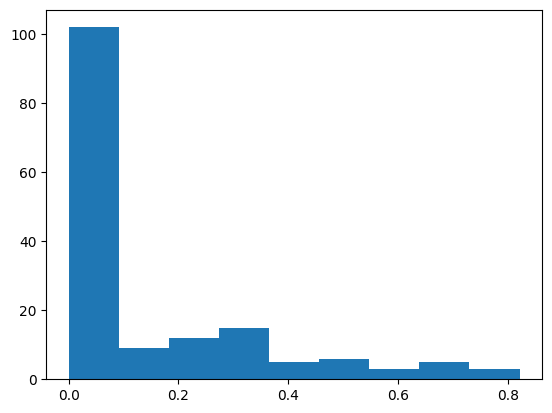

Metrics for: /home/ohm/PycharmProjects/FiFi/annotations/annotations_changes_999.xml
Length 160
Mean 0.19102665979416752
Median 0.1340518759400079
Imges with no detection: 73
Precision: 0.9469892412988273


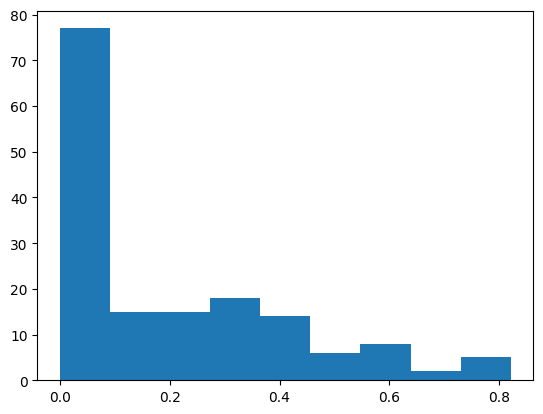

In [73]:
print_metrics(precision, ious, name=xml_file)
print_metrics(precision_compare, ious_compare, name=xml_file_compare)